1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
from scipy.stats import norm, linregress
import scipy.integrate as integrate
from IPython.display import Image
import pandas as pd
import seaborn as sns

Insert number of elements N: 500
Insert the mean of the normal distribution: 3
Insert the standard deviation of the normal distribution: 2


<ipython-input-30-55912eed1265>:36: RuntimeWarning: divide by zero encountered in power
  pu = a[0]**(-1/2)


The norm of the histogram is:  99.6000000000001
The norm of the final function interpolating the points of the histogram is:  99.60000000000008


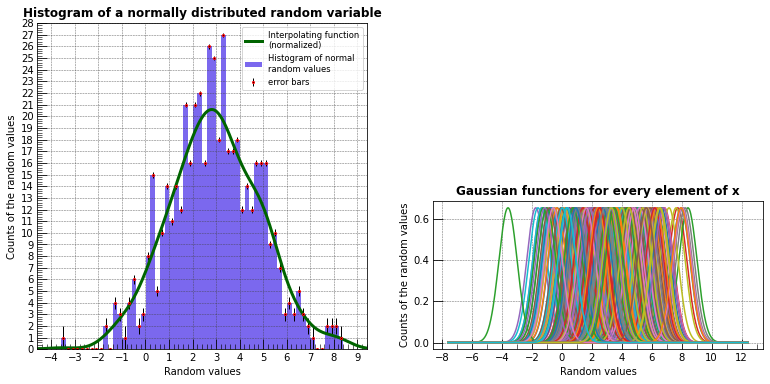

In [30]:
N = input("Insert number of elements N: ")     #tested value N = 500
N = int(N)
#N = 500
mu = input("Insert the mean of the normal distribution: ")     #tested value mu = 5
mu = float(mu)
#mu = 5
sigma = input("Insert the standard deviation of the normal distribution: ")     #tested value sigma = 2
sigma = float(sigma)
#sigma = 2

x = np.random.normal(loc=mu, scale=sigma, size=N)
mx = x.min()
Mx = x.max()

fig = plt.figure(figsize=(13, 6))
ax = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=2)
ax_1 = plt.subplot2grid((2, 2), (1, 1))

spc = 100/N
a = ax.hist(x, bins=np.arange(x.min(), x.max(), spc), label='Histogram of normal\nrandom values', color='mediumslateblue')
My = a[0].max()

ax.set_xlim(mx-1, Mx+1)
ax.set_ylim(0, My+1)
ax.set_title('Histogram of a normally distributed random variable', fontweight="bold")
ax.set_xlabel('Random values')
ax.set_ylabel('Counts of the random values')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', direction='in', length=10, grid_alpha=0.8)
ax.tick_params(which='minor', direction='in', length=5, labelsize=10, labelcolor='0.25', grid_alpha=0.8)
ax.grid(linestyle="--", linewidth=0.5, color='.25', zorder=-10)

pu = a[0]**(-1/2)
pu = np.where(pu == np.Inf, 0, pu)
bin_centers = 0.5*(a[1][1:] + a[1][:-1])

ax.errorbar(bin_centers, a[0], xerr=None, yerr=pu, linestyle='None', fmt='k.', markersize=4, linewidth=1, markeredgecolor='red', label='error bars')

var = 1.06*sigma*(N**(-1/5))
x_m = mx-(2*sigma)
x_M = Mx+(2*sigma)
X = np.linspace(x_m, x_M, N) #try to change N with something else
coord = np.zeros(len(X))

for val in x:
    Y = norm.pdf(X, loc=val, scale=var)
    coord += Y
    ax_1.plot(X, Y)

ax_1.set_title('Gaussian functions for every element of x', fontweight="bold")
ax_1.set_xlabel('Random values')
ax_1.set_ylabel('Counts of the random values')
ax_1.xaxis.set_major_locator(MultipleLocator(2))
ax_1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax_1.tick_params(which='major', direction='in', length=10, grid_alpha=0.8)
ax_1.tick_params(which='minor', direction='in', length=5, labelsize=10, labelcolor='0.25', grid_alpha=0.8)
ax_1.grid(linestyle="--", linewidth=0.5, color='.25', zorder=-10)

nrm_x = integrate.trapz(a[0], x=bin_centers)
nrm_Y = integrate.trapz(coord, x=X)
coord = (coord*nrm_x)/nrm_Y
nrm_fin = integrate.trapz(coord, x=X)
print("The norm of the histogram is: ", nrm_x)
#print("The norm of the sum of all the Gaussian functions for every value of x is: ", nrm_Y)
print("The norm of the final function interpolating the points of the histogram is: ", nrm_fin)

ax.plot(X, coord, color='darkgreen', linewidth=3, label='Interpolating function\n(normalized)')
ax.legend(loc='best', fontsize='small')

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

Insert number of categories: 3
Insert number of points: 500


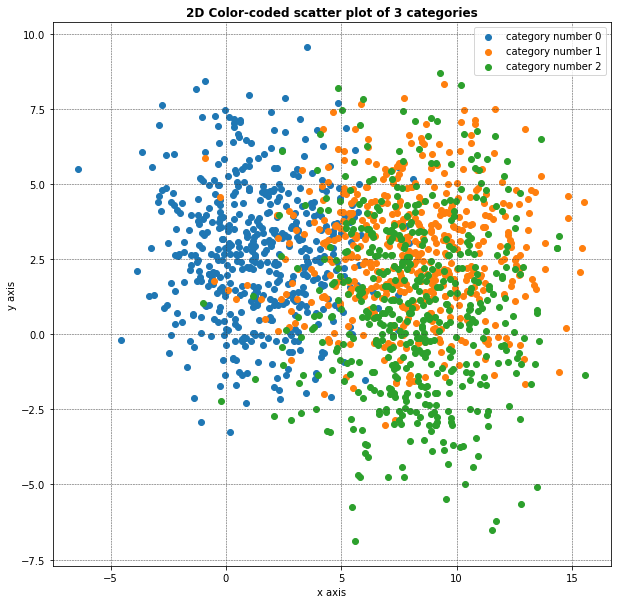

In [34]:
def cat_gen(ncat, dim):
    ncat = int(ncat)
    dim = int(dim) 
    df = pd.DataFrame()
    for i in range(0, ncat):
        ind = str(i)
        mean = 10*np.random.random((2,))
        k = 0
        while k == 0:
            c = 10*np.random.random((2,))
            cov = np.array([c, np.flip(c)])
            Tr = np.trace(cov)
            Det = np.linalg.det(cov)
            Delta = (Tr**2) - (4*Det)
            S1 = (Tr + np.sqrt(Delta))/2
            S2 = (Tr - np.sqrt(Delta))/2
            if Delta >= 0 and S1 >= 0 and S2 >= 0:
                data = np.random.multivariate_normal(mean, cov, dim)
                k += 1
            else:
                k += 0
        name1 = 'x_'+ind
        name2 = 'y_'+ind
        temp_df = pd.DataFrame(data, columns=[name1, name2])
        df = df.append(temp_df)
    return df

cat = input("Insert number of categories: ")
cat = int(cat)
N = input("Insert number of points: ")
N = int(N)

cat_gen(cat, N)

fig1, ax1 = plt.subplots(figsize=(10, 10))
for j in range(0, cat):
    num = str(j)
    col1 = 'x_'+num
    col2 = 'y_'+num
    sentence = 'category number '+num
    scatter = ax1.scatter(x=cat_gen(cat, N)[col1], y=cat_gen(cat, N)[col2], label=sentence)

ax1.legend(loc='best', fontsize='medium')
n = str(cat)
ax1.set_title('2D Color-coded scatter plot of '+n+' categories', fontweight="bold")
ax1.set_xlabel('x axis')
ax1.set_ylabel('y axis')
ax1.grid(linestyle="--", linewidth=0.5, color='.25', zorder=-10)

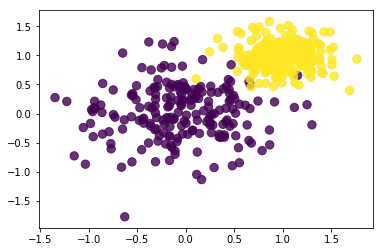

In [144]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Image('C:/Users/Sebastiano/data/two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot


Parameters of the linear fit of the data:
Slope:  0.0032597701220305835
Intercept:  -0.15432816763069473
Correlation coefficient:  0.043403510522559086
P-value:  8.717037183576464e-06
Standard error:  0.0007327014008445789


<ErrorbarContainer object of 3 artists>

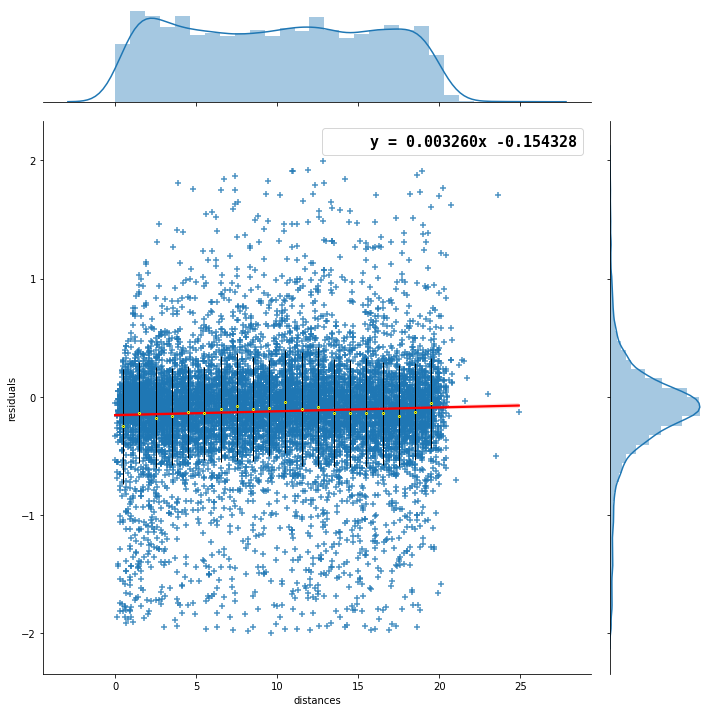

In [35]:
path='C:/Users/Sebastiano/data/residuals_261.npy'
a = np.load(path, allow_pickle=True)
dat = a.item()
Df = pd.DataFrame(dat)

Df = Df[abs(Df['residuals'])<2]

m, q, rvalue, pvalue, stderr = linregress(Df['distances'], Df['residuals'])
print("\nParameters of the linear fit of the data:")
print("Slope: ", m)
print("Intercept: ", q)
print("Correlation coefficient: ", rvalue)
print("P-value: ", pvalue)
print("Standard error: ", stderr)

annot_kws = {'prop':{'family':'monospace', 'weight':'bold', 'size':15}}
g = sns.jointplot(x="distances", y="residuals", data=Df, kind="reg", height=10, marker='+', joint_kws={'line_kws':{'color':'red'}}, annot_kws=annot_kws) # Only regression cyan (works fine)
phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
g.ax_joint.legend([phantom],['y = {:f}x {:f}'.format(m,q)], **annot_kws)

bin_info1 = np.histogram(Df['distances'], range=(0,20), bins=20)
bin_edges = bin_info1[1]
x = 0.5*(bin_edges[1:] + bin_edges[:-1])

y = np.array([])
erry = np.array([])
for l in range(0, len(bin_edges)-1):
    low = bin_edges[l]
    high = bin_edges[l+1]
    temp = Df[(Df['distances']>=low) & (Df['distances']<high)]
    y = np.append(y, temp['residuals'].mean())
    erry = np.append(erry, temp['residuals'].std())

g.ax_joint.errorbar(x, y, xerr=None, yerr=erry, linestyle='None', fmt='k.', markersize=4, linewidth=1, markeredgecolor='yellow', label='error bars')
